In [1]:
# from util import *
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [263]:
# import scipy.io as scio
# from scipy import signal
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# data_path = "/home/melodia/data/MEA_grasp/datasets_matlab/"
# electrodeID_path = '/home/melodia/proj/BCI_Project/metadata/' #path to git repo CSV files

# all_data = {}
# all_data['N'] = {i: scio.loadmat(data_path + 'i140703-001_raw-lfp-spikes_ch{}.mat'.format(str(i).zfill(2))) for i in range(1,97)}
# all_data['L'] = {i: scio.loadmat(data_path + 'l101210-001_raw-lfp-spikes_ch{}.mat'.format(str(i).zfill(2))) for i in range(1,97)}

def get_trial_time_and_label(monkey, event_want='GO-ON'):
    assert monkey in ['L', 'N']
    data = all_data[monkey][1]
    event_data = data['block']['segments'][0][0][0][0][0][0]['events'][0][2][0][0]
    assert event_data['name'] == 'TrialEvents'
    assert event_data['times_units'] == '(1.0/30000 * s)'
    samples = []
    t_trial = None
    lb_trial = None
    valid_trial = True
    valid_trial2 = False
    for event, label, time in zip(event_data['an_trial_event_labels'],
                            event_data['an_belongs_to_trialtype'],
                            event_data['times'][0]):
        if event.strip() == event_want.strip():
            t_trial = time/30000
            lb_trial = label
        if 'ERROR' in event:
            valid_trial = False
        if 'RW-ON' in event:
            valid_trial2 = True
        if event[:5] in ['TS-ON', 'NONE ']:
            if valid_trial and valid_trial2 and lb_trial:
                samples.append((t_trial, lb_trial))
            t_trial = None
            lb_trial = None
            valid_trial = True
    return samples

def get_electrodes(monkey_name, x, y, step):
    chunk_channel_id=[]
    assert monkey_name in ['L', 'N']
    if monkey_name=='L':
        df=pd.read_csv(electrodeID_path+'L.csv')
    else:
        df=pd.read_csv(electrodeID_path+'N.csv')   
    monkey_electrodes_id=df['Id'].tolist()
    start=(y-1)*10+x
    for col in range (0, step):
        for row in range (0,step):
            chunk_channel_id.append(monkey_electrodes_id[start+10*row-1])
        start=start+1   
    return chunk_channel_id

def get_st_feat(monkey, ch, start_time, window_time):
    data = all_data[monkey][ch]
    tmp = data['block']['segments'][0][0][0][0][0][0]['spiketrains'][0]
    st = None
    for i in range(tmp.shape[0]):
        if tmp[i][0][0]['an_unit_id'].item() == 1: st = tmp[i][0][0]
        elif tmp[i][0][0]['an_unit_id'].item() == 0 and st is None: st = tmp[i][0][0]
    assert st['times_units'].item() == '(1.0/30000 * s)'
    st['times'][0]
    st_op = start_time*30000
    st_ed = (start_time+window_time)*30000

    frs = []
    parts = 1
    for i in range(parts):
        sop = st_op + (st_ed-st_op)*i/parts
        sed = st_op + (st_ed-st_op)*(i+1)/parts
        frs.append(((st['times'][0] >= sop) & (st['times'][0] < sed)).sum())
    # return [((st['times'][0] >= st_op) & (st['times'][0] < st_ed)).sum()]
    return frs

def get_lfp_feat(monkey, ch, start_time, window_time):
    data = all_data[monkey][ch]
    lfp_data = data['block']['segments'][0][0][0][0][0][0]['analogsignals'][0][0][0][0]#['file_origin'][0][-3:]
    assert lfp_data['file_origin'][0][-3:] == 'ns2'
    assert lfp_data['t_start_units'] == '(1.0/1000.0*s)'
    start_time_shifted = start_time - lfp_data['t_start'].item()
    
    
    psds = []
    parts = 1
    for i in range(parts):
        op = int((start_time_shifted+window_time*i/parts)*1000)
        ed = int((start_time_shifted+window_time*(i+1)/parts)*1000)
        sig = lfp_data['signal'].squeeze()[op:ed]
        freqs, psd = signal.welch(sig, 1000, nperseg=500)
        psds.append(psd[:])
    return np.concatenate(psds)

def get_all_feat_and_labels(monkey, event_want, offset, window_time):
    trials = get_trial_time_and_label(monkey, event_want)

    all_feat = {}

    for ch in range(1,97):
        st_feat = []
        if monkey == 'N': lfp_feat = []
        for trial_t, label in trials:
            start_time = trial_t + offset
            st_feat.append(get_st_feat(monkey, ch, start_time, window_time))
            if monkey == 'N': lfp_feat.append(get_lfp_feat(monkey, ch, start_time, window_time))
        all_feat[ch] = {'st_feat': np.stack(st_feat)}
        if monkey == 'N': all_feat[ch]['lfp_feat'] = np.stack(lfp_feat)
    labels = np.stack([trial[1] for trial in trials])
    
    return all_feat, labels

def plot_heatmap(accs, vmin=0.25, vmax=1):
    cols, rows = accs.shape
    plt.imshow(accs, interpolation='nearest', extent=[0.5, 0.5+cols, 0.5, 0.5+rows],
                      cmap='bwr', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.axis('off')
    plt.show()
    
def plot_heatmap_df(df2, vmin=0.25, vmax=1):
    accs = np.zeros((df2['X'].max(), df2['Y'].max()))
    accs[df2['X']-1, df2['Y']-1] = df2['Accuracy']
    plot_heatmap(accs, vmin=vmin, vmax=vmax)

def run_single_time_window(monkey, event_want, offset, time_window, spatial_step=3):
    spatial_xid=[]
    spatial_yid=[]
    spatial_steps = []
    acc_ls=[]
    time_id=[]
    time_windows = []
    event = []
    all_feat, labels = get_all_feat_and_labels(monkey, event_want, offset, time_window)
    labels = labels.view('<U2')[::2]
    for i in range (1, 10-spatial_step+2):
        for j in range (1, 10-spatial_step+2): 
            elecs = get_electrodes(monkey, i, j, spatial_step)
            
            ## lfp start ##
            if monkey == 'N':
                data = []
                for ch in elecs:
                    if ch == -1: continue
                    data.append(all_feat[ch]['lfp_feat'])
                data = np.concatenate(data, axis=1)
                train_num=int(0.8*data.shape[0])
                lfp_train, lfp_test = data[:train_num], data[train_num:]
            
                scaler = StandardScaler()  # normalization: zero mean, unit variance
                scaler.fit(lfp_train)  # scaling factor determined from the training set

                lfp_train = scaler.transform(lfp_train)
                lfp_test = scaler.transform(lfp_test)

                pca = PCA(n_components=20)
                pca.fit(lfp_train)
                lfp_train = pca.transform(lfp_train)
                lfp_test = pca.transform(lfp_test)
            ## lfp end ##
            
            data = []
            for ch in elecs:
                if ch == -1: continue
                data.append(all_feat[ch]['st_feat'])
            data = np.concatenate(data, axis=1)
            train_num=int(0.8*data.shape[0])

            X_train, y_train, X_test, y_test = data[:train_num], labels[:train_num], data[train_num:], labels[train_num:]
            
            if monkey == 'N':
                X_train = np.concatenate([X_train, lfp_train], axis=1)
                X_test = np.concatenate([X_test, lfp_test], axis=1)
            
            # Normalize data
            scaler = StandardScaler()  # normalization: zero mean, unit variance
            scaler.fit(X_train)  # scaling factor determined from the training set

            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
            
            
#             clf = MLPClassifier(hidden_layer_sizes=(50), learning_rate_init=0.01, max_iter=500, verbose=0)
            clf = SVC(kernel='sigmoid', C=1)
            clf.fit(X_train, y_train)

            accuracy = (clf.predict(X_test) == y_test).mean()
            spatial_xid.append(i)
            spatial_yid.append(j)
            acc_ls.append(accuracy)
            time_id.append(offset)
            time_windows.append(time_window)
            event.append(event_want)
            spatial_steps.append(spatial_step)
    return pd.DataFrame(list(zip(spatial_xid, spatial_yid, spatial_steps, event, time_id, time_windows, acc_ls)),
                        columns = ['X', 'Y', 'Spatial Step', 'Event', 'Time Start', 'Time Span', 'Accuracy'])

### 1
[3] * [time start] * [

In [242]:
dfs = []
for t in tqdm(range(0, 16)):
    dfs.append(run_single_time_window('L', 'SR', (t-8)/10, 0.1, 3))
for t in tqdm(range(0, 15)):
    dfs.append(run_single_time_window('L', 'SR', (t-8)/10, 0.2, 3))

100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


In [244]:
# df = pd.concat(dfs).reset_index()
# df.to_csv('L6.csv')

In [362]:
df = pd.read_csv('L6_MotorStatus.csv')

In [323]:
df

,Unnamed: 0,index,X,Y,Spatial Step,Event,Time Start,Time Span,Accuracy,Motor_Status
0,0,0,1,1,3,SR,-0.8,0.1,0.548387,0.0
1,1,1,1,2,3,SR,-0.8,0.1,0.645161,0.0
2,2,2,1,3,3,SR,-0.8,0.1,0.580645,0.0
3,3,3,1,4,3,SR,-0.8,0.1,0.774194,0.0
4,4,4,1,5,3,SR,-0.8,0.1,0.483871,1.0
...,...,...,...,...,...,...,...,...,...,...
1979,1979,59,8,4,3,SR,0.6,0.2,0.806452,1.0
1980,1980,60,8,5,3,SR,0.6,0.2,0.806452,1.0
1981,1981,61,8,6,3,SR,0.6,0.2,0.774194,1.0
1982,1982,62,8,7,3,SR,0.6,0.2,0.806452,1.0


In [266]:
df[
    (df['Spatial Step'] == 3)
   & (df['Event'] == 'SR')
   & (df['Time Start'] == 0)
   & (df['Time Span'] == 0.2)
]

,Unnamed: 0,index,X,Y,Spatial Step,Event,Time Start,Time Span,Accuracy,Motor_Status
1536,1536,0,1,1,3,SR,0.0,0.2,0.900000,0.0
1537,1537,1,1,2,3,SR,0.0,0.2,0.966667,0.0
1538,1538,2,1,3,3,SR,0.0,0.2,0.933333,0.0
1539,1539,3,1,4,3,SR,0.0,0.2,1.000000,0.0
1540,1540,4,1,5,3,SR,0.0,0.2,1.000000,2.0
...,...,...,...,...,...,...,...,...,...,...
1595,1595,59,8,4,3,SR,0.0,0.2,0.900000,1.0
1596,1596,60,8,5,3,SR,0.0,0.2,0.966667,1.0
1597,1597,61,8,6,3,SR,0.0,0.2,0.933333,1.0
1598,1598,62,8,7,3,SR,0.0,0.2,0.933333,1.0


In [274]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

In [338]:
df2 = df[(df['Spatial Step']==3) & (df['Event']=='SR') & (df['Time Start']==0.6) & (df['Time Span']==0.2)]
# plot_heatmap_df(df2, vmin=0.5)
ac0 = df2[df2['Motor_Status']==0]['Accuracy']
ac1 = df2[df2['Motor_Status']==1]['Accuracy']
gauss = True
for eone in [ac0, ac1]:
    p = shapiro(eone)[1]
    if p < 0.05:
        gauss = False
        break
s1, s2 = ac0, ac1
if gauss:
    p2 = ttest_ind(s1,s2, alternative='greater')[1]
else:
    p2 = mannwhitneyu(s1,s2, alternative='greater')[1]
p2

0.9114809510614704

In [307]:
ac1.mean()

0.6823129251700683

In [352]:
df2 = df[(df['Spatial Step']==3) & (df['Event']=='SR') & (df['Time Span']==0.2) & (df['X']==1) & (df['Y']==1)]
df2['Motor_Status'].iloc[0]

0.0

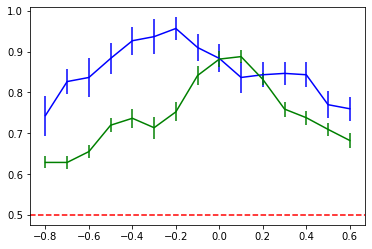

In [363]:
acc_prem = []
acc_m = []
for i in range(1, 9):
    for j in range(1, 9):
        df2 = df[(df['Spatial Step']==3) & (df['Event']=='SR') & (df['Time Span']==0.2) & (df['X']==i) & (df['Y']==j)]
        if df2['Motor_Status'].iloc[0] == 0:
            acc_prem.append(df2['Accuracy'])
        elif df2['Motor_Status'].iloc[0] == 1:
            acc_m.append(df2['Accuracy'])
#         color = {0: 'b', 1: 'g'}[df2['Motor_Status'].iloc[0]]
# plt.plot(df2['Time Start'], df2['Accuracy'], c=color)
acc_prem = np.array(acc_prem)
acc_m = np.array(acc_m)
plt.errorbar(df2['Time Start'], acc_prem.mean(axis=0), acc_prem.std(axis=0)/np.sqrt(acc_prem.shape[0]), color='b')
plt.errorbar(df2['Time Start'], acc_m.mean(axis=0), acc_m.std(axis=0)/np.sqrt(acc_m.shape[0]), color='g')
plt.axhline(0.5, linestyle='--', color='r')

In [262]:
df = run_single_time_window('L', 'SR', -0.6, 0.2, 3)

(116, 9)
(30, 9)


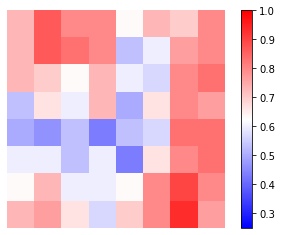

In [308]:
plot_heatmap_df(df2)

In [20]:
scaler = StandardScaler()
scaler.fit([[1, 2], [0, -2], [1, 10], [0, -10]])
scaler.var_

array([ 0.25, 52.  ])